In [2]:
import tensorflow as tf, gdown
!pip install opencv-python
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import cv2
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio #numpy array to gifs

In [4]:
 len(tf.config.experimental.list_physical_devices('GPU'))

1

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

### BUILD DATA LOADING FUNCTIIONS

In [7]:
import gdown # to grab data @ gdrive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')
# !gdown https://drive.google.com/file/d/https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL/view?usp=sharing

In [10]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path) #cap = ptr to video
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean),tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmopqrstuvwxyz'?!123456789 "]

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is :{char_to_num.get_vocabulary()}"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is :['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =39)


In [13]:
char_to_num(['b','d','f'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 4, 6])>

In [14]:
num_to_char([2, 4, 6])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'b', b'd', b'f'], dtype=object)>

In [15]:
def load_alignments(path:str) -> List[float]:
  with open(path, 'r') as f:
    lines = f.readlines()
  tokens = []
  for line in lines:
    line = line.split()
    if line[2]!='sil':
      tokens = [*tokens,' ',line[2]]
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]

In [16]:
def load_data(path: str):
  path = bytes.decode(path.numpy())
  file_name = path.split('/')[-1].split('.')[0]  # path splitting for windows
  video_path = os.path.join('/content','drive','MyDrive','ML-PROJECTS','data','s1',f'{file_name}.mpg')
  print(video_path)
  alignment_path = os.path.join('/content','drive','MyDrive','ML-PROJECTS','data','alignments','s1',f'{file_name}.align')
  frames = load_video(video_path)
  frames = np.squeeze(frames, axis=-1)
  alignments = load_alignments(alignment_path)

  return frames, alignments

In [17]:
test_path = '/content/drive/MyDrive/ML-PROJECTS/data/s1/bbaf2n.mpg'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('UTF-8').split('/')[-1].split('.')[0]

'bbaf2n'

/content/drive/MyDrive/ML-PROJECTS/data/s1/bbaf2n.mpg


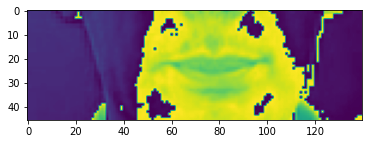

In [19]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
# plt.imshow(np.squeeze(frames[20], axis=-1))
plt.imshow(frames[30])

In [20]:
# num_to_char(alignments.numpy())
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy() ])

<tf.Tensor: shape=(), dtype=string, numpy=b'bi blue at f two ow'>

In [21]:
def mappable_function(path:str) -> List[str] :
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

###2. Create Data PipeLine

In [22]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/ML-PROJECTS/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# splitting data
train = data.take(450)
test_data = data.skip(450)

In [23]:
# converts  tf dataset into py generator
frames, alignments = data.as_numpy_iterator().next()

/content/drive/MyDrive/ML-PROJECTS/data/s1/lgas3s.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/pgak5a.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/brag1a.mpg


In [24]:
len(frames)

2

In [25]:
alignments

array([[12,  1, 24, 38,  7, 17,  5,  5,  0, 38,  1, 19, 38, 18, 38, 19,
         8, 17,  5,  5, 38, 18, 14, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [15, 12,  1,  3,  5, 38,  7, 17,  5,  5,  0, 38,  1, 19, 38, 11,
        38,  6,  9, 21,  5, 38,  1,  7,  1,  9,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [26]:
test = data.as_numpy_iterator()
val = test.next() 
val[0].shape
# val[0] includes frames, val[1] includes alignments

/content/drive/MyDrive/ML-PROJECTS/data/s1/brwg8p.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/pgij8n.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/bwag7a.mpg

(2, 75, 46, 140)

In [27]:
imageio.mimsave('/content/drive/MyDrive/ML-PROJECTS/data/animation.gif', val[0][1], fps=10)

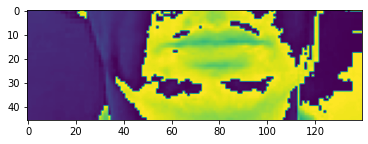

In [28]:
# 0: videos, 0:1st video of the batch(0-1), 0: return 1st frame in the video(0-74)
plt.imshow(val[0][1][70])

In [29]:
val[1][0].shape

(40,)

In [30]:
tf.strings.reduce_join([num_to_char(num) for num in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bi red with g eight please'>

###3. DESIGN THE DEEP NEURAL NETWORK 

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [49]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+2, kernel_initializer='he_normal', activation='softmax'))

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [51]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [52]:
yhat[0].shape

(75, 41)

In [53]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([15, 15, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 14, 14])>

In [54]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ppppppppppppppppppppppppppppppppppfffffffffffffpppppppppppppppppppppppppppo'>

In [55]:
model.input_shape

(None, 75, 46, 140, 1)

In [56]:
model.output_shape

(None, 75, 41)

###4. SETUP TRAINING OPTIONS AND TRAIN

In [57]:
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else: return lr * tf.math.exp(-0.1)

In [58]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
  input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64')
  label_len = tf.cast(tf.shape(y_true)[1], dtype='int64')

  input_len *= tf.ones(shape=(batch_len,1), dtype='int64')
  label_len *= tf.ones(shape=(batch_len,1), dtype='int64')

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)
  return loss

In [59]:
class ProduceExample(tf.keras.callbacks.Callback):
  def __init__(self, dataset) -> None:
    self.dataset = dataset.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs=None) -> None:
    data = self.dataset.next()
    yhat = self.model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
    for x in range(len(yhat)):
      print("Original:", tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('UTF-8'))
      print("Prediction:", tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('UTF-8'))
      print('~'*100)

In [60]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [61]:
checkpoint_callback = ModelCheckpoint(os.path.join('/content','drive','MyDrive','ML-PROJECTS','models','checkpoints'), monitor='loss', save_weights_only=True)

In [62]:
schedule_callback = LearningRateScheduler(scheduler)

In [63]:
example_callback = ProduceExample(data)

In [64]:
model.fit(train,validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


KeyboardInterrupt: ignored

In [65]:
model.load_weights('/content/drive/MyDrive/ML-PROJECTS/models-checkpoint-96/checkpoint')

In [66]:
sample = test_data.as_numpy_iterator().next()

/content/drive/MyDrive/ML-PROJECTS/data/s1/lwar6n.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/lgwg2n.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/bwwh5a.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/bgbbzn.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/swio2p.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/sbig4n.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/lgas3s.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/sbwh8p.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/swwv7s.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/lbby4p.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/pwaq3a.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/sbig7a.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/sbwu4n.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/pwid1a.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/sgbc7s.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/pgix9a.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/lgiz3s.mpg
/content/drive/MyDrive/ML-PROJECTS/data/s1/bwaa3a.mpg
/content/drive/MyDrive/ML-PR

In [67]:
dir(test)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_iterator',
 'next']

In [68]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 1s/step


In [69]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white sp by f three soo'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white with e oe soo'>]

In [70]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
decoded

array([[12,  1, 25, 39, 23,  8,  9, 20,  5, 39, 19, 16, 39,  2, 25, 39,
         6, 39, 20,  8, 18,  5,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [16, 12,  1,  3,  5, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8,
        39, 15, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [71]:
print('~'*100, "PREDICTIONS")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lazxhiuetqbzfuhseetppo'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'qlacexhiuexiuhpoetppo'>]

In [72]:
sample = load_data(tf.convert_to_tensor('/content/drive/MyDrive/ML-PROJECTS/data/s1/sbwu5s.mpg'))

/content/drive/MyDrive/ML-PROJECTS/data/s1/sbwu5s.mpg


In [73]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with u five soo'>]

In [74]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [75]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [76]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'teublvexiuhvfiwetppo'>]